In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import random

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, SeparableConv2D,BatchNormalization, Conv2D, InputLayer

In [2]:
path = "../input/cell-images-for-detecting-malaria/cell_images"
labels = ["Parasitized", "Uninfected"]

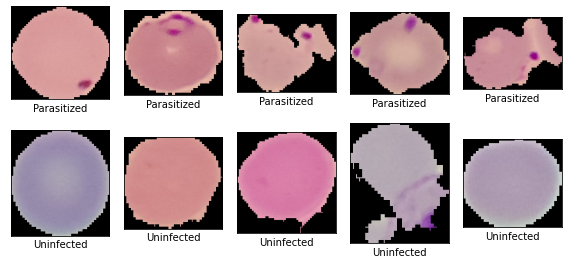

In [3]:
fig, axs = plt.subplots(len(labels), 5, figsize = (8,4))

class_len = {}
for i, c in enumerate(labels):
    class_path = os.path.join(path, c)
    all_images = os.listdir(class_path)
    sample_images = random.sample(all_images, 5)
    class_len[c] = len(all_images)
    
    for j, image in enumerate(sample_images):
        img_path = os.path.join(class_path, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = c, xticks = [], yticks = [])

fig.tight_layout()

In [4]:
TARGET_SIZE = (224,224)

datagen_train = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2,
    rotation_range = 5,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range = 0.01
)

datagen_val = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2 
)    

train_generator = datagen_train.flow_from_directory(
    directory = path,
    classes = labels,
    seed = 42,
    batch_size = 32,
    target_size = TARGET_SIZE, 
    shuffle = True,
    subset = 'training'
)

val_generator = datagen_val.flow_from_directory(
    directory =path,
    classes = labels,
    seed = 42,
    batch_size = 32,
    target_size = TARGET_SIZE,
    shuffle = True,
    subset = 'validation'
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [5]:
#define the metrics to evaluate the perfomance
MyList = ["accuracy"]
MyList += [Recall(class_id = i) for i in range(len(labels))] 
MyList += [Precision(class_id = i) for i in range(len(labels))]



In [6]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2,activation='softmax'))

In [7]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = MyList)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

In [9]:
#To overcome the class imbalance, give weightage to classes
total_wt = sum(class_len.values())

weights = {
    0: 0.5 * (1 - class_len[labels[0]]/total_wt),
    1: 0.5 * (1 - class_len[labels[1]]/total_wt)
}
weights

{0: 0.25, 1: 0.25}

In [10]:
#to prevent overfitting
earlystopping = EarlyStopping(monitor = "val_loss",patience = 10,verbose=1)
# save the best model with lower loss
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", save_best_only = True)
#to vary to learning rate when model starts to overfit
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.00001, mode='min',verbose=1)

In [11]:
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = val_generator.n//val_generator.batch_size

In [12]:
history = model.fit(
    train_generator,
    class_weight = weights,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data = val_generator,
    epochs = 100, 
    callbacks = [reduce_lr,earlystopping,checkpointer]
)

Epoch 1/100
689/689 [==============================] - 376s 540ms/step - loss: 0.1720 - accuracy: 0.5344 - recall: 0.5677 - recall_1: 0.5010 - precision: 0.5326 - precision_1: 0.5368 - val_loss: 0.4516 - val_accuracy: 0.9297 - val_recall: 0.9408 - val_recall_1: 0.9185 - val_precision: 0.9204 - val_precision_1: 0.9394
Epoch 2/100
689/689 [==============================] - 258s 374ms/step - loss: 0.0868 - accuracy: 0.9159 - recall: 0.8655 - recall_1: 0.9661 - precision: 0.9621 - precision_1: 0.8784 - val_loss: 0.2496 - val_accuracy: 0.9304 - val_recall: 0.9073 - val_recall_1: 0.9535 - val_precision: 0.9512 - val_precision_1: 0.9115
Epoch 3/100
689/689 [==============================] - 258s 375ms/step - loss: 0.0611 - accuracy: 0.9397 - recall: 0.9166 - recall_1: 0.9630 - precision: 0.9616 - precision_1: 0.9196 - val_loss: 0.2305 - val_accuracy: 0.9284 - val_recall: 0.8887 - val_recall_1: 0.9680 - val_precision: 0.9652 - val_precision_1: 0.8970
Epoch 4/100
689/689 [======================

Found 5510 images belonging to 2 classes.


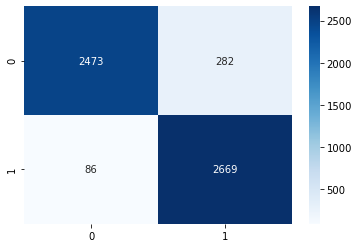

In [13]:
# Confusion Matrix 
val_generator = datagen_val.flow_from_directory(
    directory = path,
    classes = labels,
    seed = 42,
    batch_size = 32, 
    shuffle = False,
    subset = 'validation'
)

# Obtain predictions
pred = model.predict(val_generator) # Gives class probabilities
pred = np.round(pred) # Gives one-hot encoded classes
pred = np.argmax(pred, axis = 1) # Gives class labels

# Obtain actual labels
actual = val_generator.classes
    
# Now plot matrix
cm = confusion_matrix(actual, pred, labels = [0, 1])
sns.heatmap(
    cm, 
    cmap="Blues",
    annot = True, 
    fmt = "d"
)
plt.show()

In [14]:
# Classification Report
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2755
           1       0.90      0.97      0.94      2755

    accuracy                           0.93      5510
   macro avg       0.94      0.93      0.93      5510
weighted avg       0.94      0.93      0.93      5510



In [15]:
model.save("Malaria_model.h5")